In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

folder_path = '/content/drive/My Drive/Google_Colab/Selfie_Image_Dataset'
os.chdir(folder_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Loading Data
X = pickle.load(open('X_2.pickle', 'rb'))
targets = pickle.load(open('targets.pickle', 'rb'))

I decided to build a classifier that will tell if someone's images have harsh lighting, in order to see who a camera or lighitng company can advertise to.

# Proprocessing

In [4]:
# Creating a target for the harsh lighting 
hl_target = targets[['image_id', 'harsh_lighting']]
hl_target.head()

,image_id,harsh_lighting
0,00a454da495e11e28a7322000a1fa414_6,0
1,00cddb96ac4c11e3a30212279ba1b65f_6,0
2,01cdd7aa1a1a11e2aaa822000a1fb0dd_6,0
3,024696bead0c11e389d50ec42b3b1b1c_6,0
4,026df048221a11e2b52122000a1fa4b5_6,0


In [5]:
# Checking length of X series
len(X)

46218

In [6]:
# Checking length of hl_target dataframe
len(hl_target)

46836

In [7]:
# Merging the same images from each dataset to get rid of the additional samples we have

hl_target['img_id'] = hl_target['image_id'] + '.jpg'
hl_target.drop('image_id', axis=1, inplace=True)

df = pd.merge(X, hl_target, on=['img_id'])

df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,X_values,img_id,harsh_lighting
0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.007843138], [0...",926438_238867309635794_89266024_a.jpg,0
1,"[[[0.2784314, 0.20784314, 0.29411766], [0.2862...",10011232_691357474264885_977704241_a.jpg,0
2,"[[[0.57254905, 0.53333336, 0.5294118], [0.6078...",10013002_1385091345104568_498584412_a.jpg,0
3,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",10245971_226416264219711_591423641_a.jpg,0
4,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",925448_278326815663194_210209027_a.jpg,0


In [8]:
df['harsh_lighting'].value_counts()

0    43677
1     2541
Name: harsh_lighting, dtype: int64

In [10]:
# Upsampling the 1 label values for 'harsh_lighting' to even out the two classes
from sklearn.utils import resample

non_harsh_df = df[df['harsh_lighting'] == 0]
harsh_df = df[df['harsh_lighting'] == 1]

df_harsh_upsampled = resample(harsh_df, 
                              replace=True, # samples with replacement
                              n_samples=df['harsh_lighting'].value_counts()[0],
                              random_state=101) 

upsampled_df = pd.concat([non_harsh_df, df_harsh_upsampled])

upsampled_df['harsh_lighting'].value_counts()

1    43677
0    43677
Name: harsh_lighting, dtype: int64

In [11]:
X = upsampled_df['X_values']
y = upsampled_df['harsh_lighting']

In [23]:
# Reshaping X to a 4D array
X = np.concatenate(np.array(X), axis=0).reshape(len(X), 32, 32, 3)

In [25]:
# Splitting the dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Building Initial Model

In [26]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 128)         512       
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

In [27]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
tensorboard = TensorBoard(log_dir='logs/')

os.chdir('/conten')

In [28]:
model.fit(X_train, y_train, epochs=5, batch_size=500, validation_data=(X_test, y_test),
          callbacks=[early_stopping, tensorboard])

Epoch 1/5
123/123 [==============================] - 100s 814ms/step - loss: 0.6595 - accuracy: 0.6434 - val_loss: 0.6627 - val_accuracy: 0.6092
Epoch 2/5
123/123 [==============================] - 100s 812ms/step - loss: 0.5323 - accuracy: 0.7348 - val_loss: 0.6516 - val_accuracy: 0.6073
Epoch 3/5
123/123 [==============================] - 100s 812ms/step - loss: 0.4717 - accuracy: 0.7832 - val_loss: 0.6028 - val_accuracy: 0.6617
Epoch 4/5
123/123 [==============================] - 100s 814ms/step - loss: 0.4201 - accuracy: 0.8213 - val_loss: 0.5074 - val_accuracy: 0.7464
Epoch 5/5
123/123 [==============================] - 100s 815ms/step - loss: 0.3758 - accuracy: 0.8482 - val_loss: 0.4112 - val_accuracy: 0.8352


In [29]:
predictions = model.predict(X_test)

In [30]:
class_predictions = [1 if prediction >= 0.5 else 0 for prediction in predictions]

In [34]:
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(cm, classes, figname, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Reds):
 """
 This function prints and plots the confusion matrix.
 Normalization can be applied by setting `normalize=True`.
 """
 import numpy as np
 import matplotlib.pyplot as plt
 import itertools
 import seaborn as sns
 if normalize:
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  print('Normalized confusion matrix')
 else:
  print('Confusion matrix, without normalization')

  sns.set_style('dark')

  plt.figure(figsize=(8,8))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  #plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
    horizontalalignment='center',
    color='white' if cm[i, j] > thresh else 'black')
  
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()
  plt.savefig(figname)

In [33]:
print(classification_report(class_predictions, y_test))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83     11848
           1       0.88      0.80      0.84     14359

    accuracy                           0.84     26207
   macro avg       0.84      0.84      0.83     26207
weighted avg       0.84      0.84      0.84     26207



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Confusion matrix, without normalization


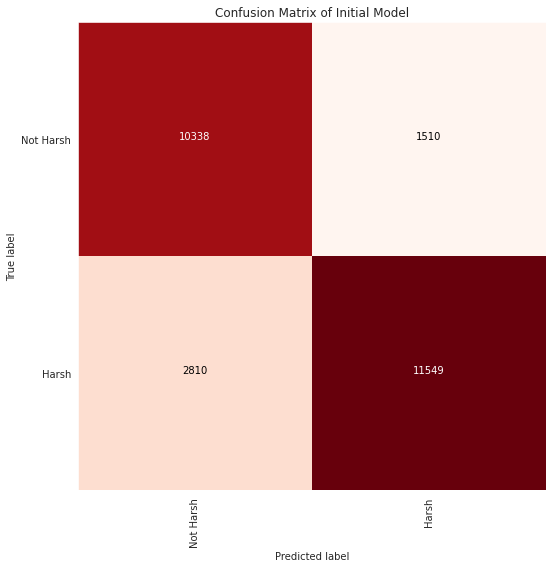

In [35]:
cm = confusion_matrix(class_predictions, y_test)

plot_confusion_matrix(cm, classes=['Not Harsh', 'Harsh'], figname='Confusion Matrix',
                      title='Confusion Matrix of Initial Model')

It looks like the inital model does a good job of determining whether an image has harsh or non harsh lighting. The only thing to improve it would be to run it for a few more epochs.

In [44]:
# Saving Model
model.save('Initial_Harsh_Lighting_Classifier_Model')
model.save('Initial_Harsh_Lighting_Classifier_Model.h5')

INFO:tensorflow:Assets written to: Initial_Harsh_Lighting_Classifier_Model/assets
